In [ ]:
#@title Librerias
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import sympy as sp
sp.init_printing()
import pandas as pd
import urllib.request

# Actividad 05: Interpolación

---
### Profesor: Juan Marcos Marín
### Nombre: ______
*Métodos computacionales 2025-I*

---

# 1
Supongamos que queremos interpolar la función  $f(x)=\sin(x)$  usando los puntos  $x_0=0$ ,  $x_1=\pi/2$ , y  $x_2=\pi$.

Encuentre el polinomio de interpolación de Lagrange y el error asociado al misma. Recuerde que el error de interpolación de Lagrange puede expresarse explícitamente como:

\begin{equation}
f(x) - P(x) = \epsilon = \frac{1}{(n+1)!} f^{(n+1)}(\xi)(x - x_0)(x - x_1) ... (x - x_n)
\end{equation}

Donde:
- $f^{(n+1)}(\xi)$ es la derivada de orden $n$ de la función $f(x)$ evaluada en algún punto $\xi$ en el intervalo de interpolación.

- Repita el numeral anterior, pero para los polinomios de interpolación de Hermite, conociendo que:


$$
f(x) - P(x) = \epsilon = \frac{f^{(2n+2)}(\xi)}{(2n+2)!} \prod_{i=0}^{n} (x - x_i)^2
$$

*Nota: recuerde que los indices en python inician en 0, luego si tenemos $n+1$ datos el polinomio es de orden $n$*

In [11]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# Variables simbólicas
x = sp.symbols('x')

x_valores = [0, np.pi/2, np.pi]
y_valores = [np.sin(xi) for xi in x_valores]  # sin(x) en los puntos

#Polinomio de interpolación de Lagrange
def lagrange_pol(x_valores, y_valores):
    n = len(x_valores)
    L = 0
    for i in range(n):
        xi, yi = x_valores[i], y_valores[i]
        li = 1
        for j in range(n):
            if i != j:
                li *= (x - x_valores[j]) / (xi - x_valores[j])
        L += yi * li
    return sp.simplify(L)

# Calcular el polinomio
P_lagrange = lagrange_pol(x_valores, y_valores)
print("Polinomio de Lagrange:")
sp.pprint(P_lagrange)
###########################
# 2. Error teórico de Lagrange
n = len(x_valores) - 1
f = sp.sin(x)
f_derivada = f.diff(x, n + 1)
ξ = sp.Symbol('ξ')  # símbolo para el punto desconocido ξ
error_lagrange = (f_derivada.subs(x, ξ) / sp.factorial(n + 1))
for xi in x_valores:
    error_lagrange *= (x - xi)
error_lagrange = sp.simplify(error_lagrange)

print("\nError teórico de interpolación de Lagrange:")
sp.pprint(error_lagrange)

# 3. Polinomio de Hermite
# Valores de derivada de sin(x)
y_prime_valores = [np.cos(xi) for xi in x_valores]

# Hermite interpolation
def hermite_pol(x_vals, y_vals, y_prime_vals):
    n = len(x_vals)
    z = []
    Q = []

    for i in range(n):
        z += [x_valores[i], x_valores[i]]
        Q.append([y_valores[i]])
        Q.append([y_valores[i]])

    m = 2 * n
    for i in range(1, m):
        for j in range(m - i):
            if i == 1 and j % 2 == 0:
                Q[j].append(y_prime_valores[j // 2])
            else:
                num = Q[j+1][i-1] - Q[j][i-1]
                denom = z[j+i] - z[j]
                Q[j].append(num / denom)

    # Construir el polinomio
    H = Q[0][0]
    prod = 1
    for i in range(1, m):
        prod *= (x - z[i-1])
        H += Q[0][i] * prod
    return sp.simplify(H)

P_hermite = hermite_pol(x_valores, y_valores, y_prime_valores)

print("\nPolinomio de Hermite:")
sp.pprint(P_hermite)

# 4. Error teórico Hermite
m = len(x_valores)
f_2_deriv = f.diff(x, 2 * m)
error_hermite = (f_2_deriv.subs(x, ξ) / sp.factorial(2 * m))
for xi in x_valores:
    error_hermite *= (x - xi)**2
error_hermite = sp.simplify(error_hermite)

print("\nError teórico de interpolación de Hermite:")
sp.pprint(error_hermite)


Polinomio de Lagrange:
x⋅(1.27323954473516 - 0.405284734569351⋅x)

Error teórico de interpolación de Lagrange:
-x⋅(x - 3.14159265358979)⋅(x - 1.5707963267949)⋅cos(ξ) 
───────────────────────────────────────────────────────
                           6                           

Polinomio de Hermite:
  ⎛                      4                       3                      2      ↪
x⋅⎝2.20871852879411e-18⋅x  + 0.0352495783421514⋅x  - 0.221479632723681⋅x  + 0. ↪

↪                         ⎞
↪ 0295895073584509⋅x + 1.0⎠

Error teórico de interpolación de Hermite:
                     2                          2                          2   ↪
-0.0338226010534731⋅x ⋅(0.318309886183791⋅x - 1) ⋅(0.636619772367581⋅x - 1) ⋅s ↪

↪      
↪ in(ξ)


# 2

En física nuclear se calcula la sección eficaz de dispersión (scattering cross section) a partir de experimentos de colisiones, se sabe a partir de la teoría que la sección eficaz se describe por la formula de Breit-Wigner,

$$\sigma(E)=\frac{\sigma_0}{(E-E_r)^2+\frac{\Gamma^2}{4}}$$

donde $E$ es la energía y $E_r,\sigma_0, \Gamma$ son parámetros a ajustar; el valor predicho es $(E_r,\Gamma) = (78, 55)$ MeV; donde $\sigma_0$ se puede calcular ahora a partir de la fórmula simplemente remplazando cualquier par de puntos de la tabla.

A partir de los valores de energía,


```
Energia  = np.array([0   , 25  , 50  , 75  , 100 , 125 , 150 , 175 , 200])
sigma_exp= np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])

```

* Calcule los polinomios de Lagrange, Newton y Hermite.

* Haga un gráfico de los polinomios junto con la función original.

* Finalmente, a partir de la diferencia $|f(x) - P_n(x)|$ calcule el máximo   error asociado a cada uno de ellos. ¿Cuál será el mejor?

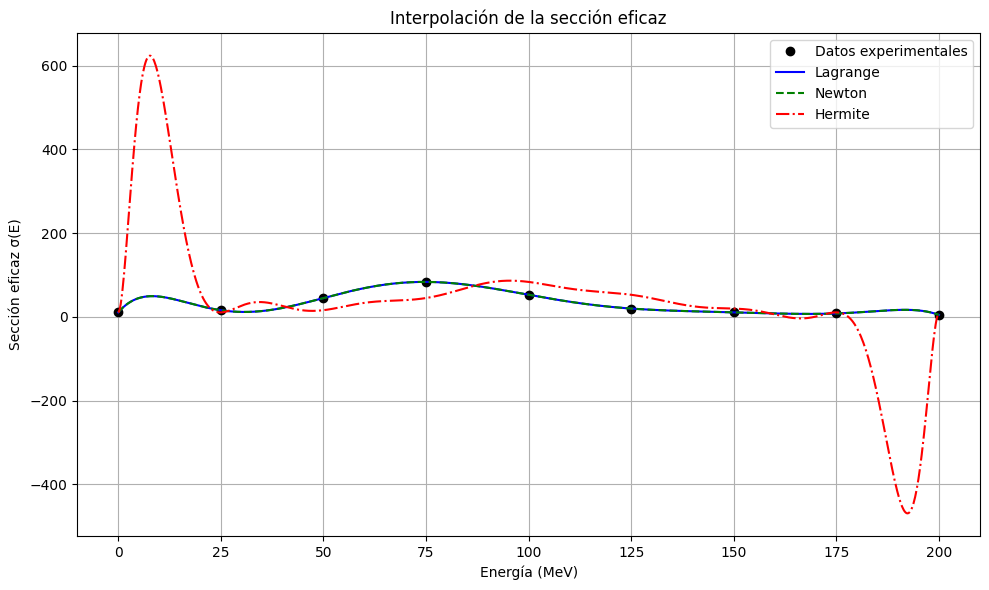

Error máximo de Lagrange: 5.445053297137292e-09
Error máximo de Newton  : 1.952593642329248e-09
Error máximo de Hermite : 38.49999185055494


In [13]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# Datos
Energia = np.array([0, 25, 50, 75, 100, 125, 150, 175, 200], dtype=float)
sigma_exp = np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7], dtype=float)

# Variable simbólica
x = sp.Symbol('x')


# Polinomio de Lagrange
def lagrange_pol(x_data, y_data):
    n = len(x_data)
    P = 0
    for i in range(n):
        L = 1
        for j in range(n):
            if i != j:
                L *= (x - x_data[j]) / (x_data[i] - x_data[j])
        P += y_data[i] * L
    return sp.simplify(P)


# Polinomio de Newton
def Newton_pol(x_data, y_data):
    n = len(x_data)
    coef = np.copy(y_data)
    for j in range(1, n):
        coef[j:n] = (coef[j:n] - coef[j - 1:n - 1]) / (x_data[j:n] - x_data[0:n - j])
    return coef

def newton_pol(x_data, coef):
    n = len(coef)
    P = coef[0]
    for i in range(1, n):
        term = coef[i]
        for j in range(i):
            term *= (x - x_data[j])
        P += term
    return sp.simplify(P)

# Polinomio de Hermite
def hermite_pol(x_data, y_data):
    n = len(x_data)
    z = np.zeros(2 * n)
    Q = np.zeros((2 * n, 2 * n))
    for i in range(n):
        z[2 * i] = z[2 * i + 1] = x_data[i]
        Q[2 * i][0] = Q[2 * i + 1][0] = y_data[i]
    for i in range(n):
        if i == 0:
            Q[2 * i + 1][1] = 0
        else:
            Q[2 * i + 1][1] = (Q[2 * i + 1][0] - Q[2 * i - 1][0]) / (z[2 * i + 1] - z[2 * i - 1])
        Q[2 * i][1] = Q[2 * i + 1][1]
    for j in range(2, 2 * n):
        for i in range(2 * n - j):
            Q[i][j] = (Q[i + 1][j - 1] - Q[i][j - 1]) / (z[i + j] - z[i])
    H = Q[0][0]
    for i in range(1, 2 * n):
        term = Q[0][i]
        for j in range(i):
            term *= (x - z[j])
        H += term
    return sp.simplify(H)

################################
# Construcción de polinomios

P_lagrange = lagrange_pol(Energia, sigma_exp)
coef_newton = Newton_pol(Energia, sigma_exp)
P_newton = newton_pol(Energia, coef_newton)
P_hermite = hermite_pol(Energia, sigma_exp)

################################
# Evaluación numérica
# ----------------------------
Px_lagrange = sp.lambdify(x, P_lagrange, 'numpy')
Px_newton = sp.lambdify(x, P_newton, 'numpy')
Px_hermite = sp.lambdify(x, P_hermite, 'numpy')

x_vals = np.linspace(0, 200, 1000)
y_lagrange = Px_lagrange(x_vals)
y_newton = Px_newton(x_vals)
y_hermite = Px_hermite(x_vals)

##########################
# Gráfica

plt.figure(figsize=(10, 6))
plt.plot(Energia, sigma_exp, 'ko', label='Datos experimentales')
plt.plot(x_vals, y_lagrange, 'b-', label='Lagrange')
plt.plot(x_vals, y_newton, 'g--', label='Newton')
plt.plot(x_vals, y_hermite, 'r-.', label='Hermite')
plt.xlabel("Energía (MeV)")
plt.ylabel("Sección eficaz σ(E)")
plt.title("Interpolación de la sección eficaz")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##########################
# Error máximo

err_lagrange = np.abs(Px_lagrange(Energia) - sigma_exp)
err_newton = np.abs(Px_newton(Energia) - sigma_exp)
err_hermite = np.abs(Px_hermite(Energia) - sigma_exp)

print("Error máximo de Lagrange:", np.max(err_lagrange))
print("Error máximo de Newton  :", np.max(err_newton))
print("Error máximo de Hermite :", np.max(err_hermite))


# 3
Consideremos la función:
\begin{equation*}
     f(x) = \frac{1}{1+25x^2}
\end{equation*}
en el intervalo $[-1, 1]$, definamos un conjunto de puntos $n+1$  equiespaciados en $[-1,1]$.

* Representar gráficamente la función junto al polinomio de interpolación de Lagrange, $p_n(x)$, para $n=\{ 4, 8, 12, 16, 20 \}$.
* Comprobar gráficamente cómo el error aumenta con $n$. Emplee la libreria, simbolica de `sympy` y encuente el error en la interpolación. La cota del  error , viene dado por:
\begin{equation}
f(x) - P(x) = \epsilon = \frac{1}{(n+1)!} f^{(n+1)}(\xi)(x - x_0)(x - x_1) ... (x - x_n)
\end{equation},

emplee la libreria simbólica para realizar la estimación de dicha cuota, sólo para $n = 4$, en el punto $x=0.5$.

* Repita la parte inicial para el conjunto de $p_n(x)$ con $n=\{ 4, 8, 12, 16, 20 \}$, usando la interpolación de Hermite, ¿existe alguna diferencia?

* Usando los datos del numeral anterior ahora usando el método `CubicSpline` realiza la interpolación y concluya.

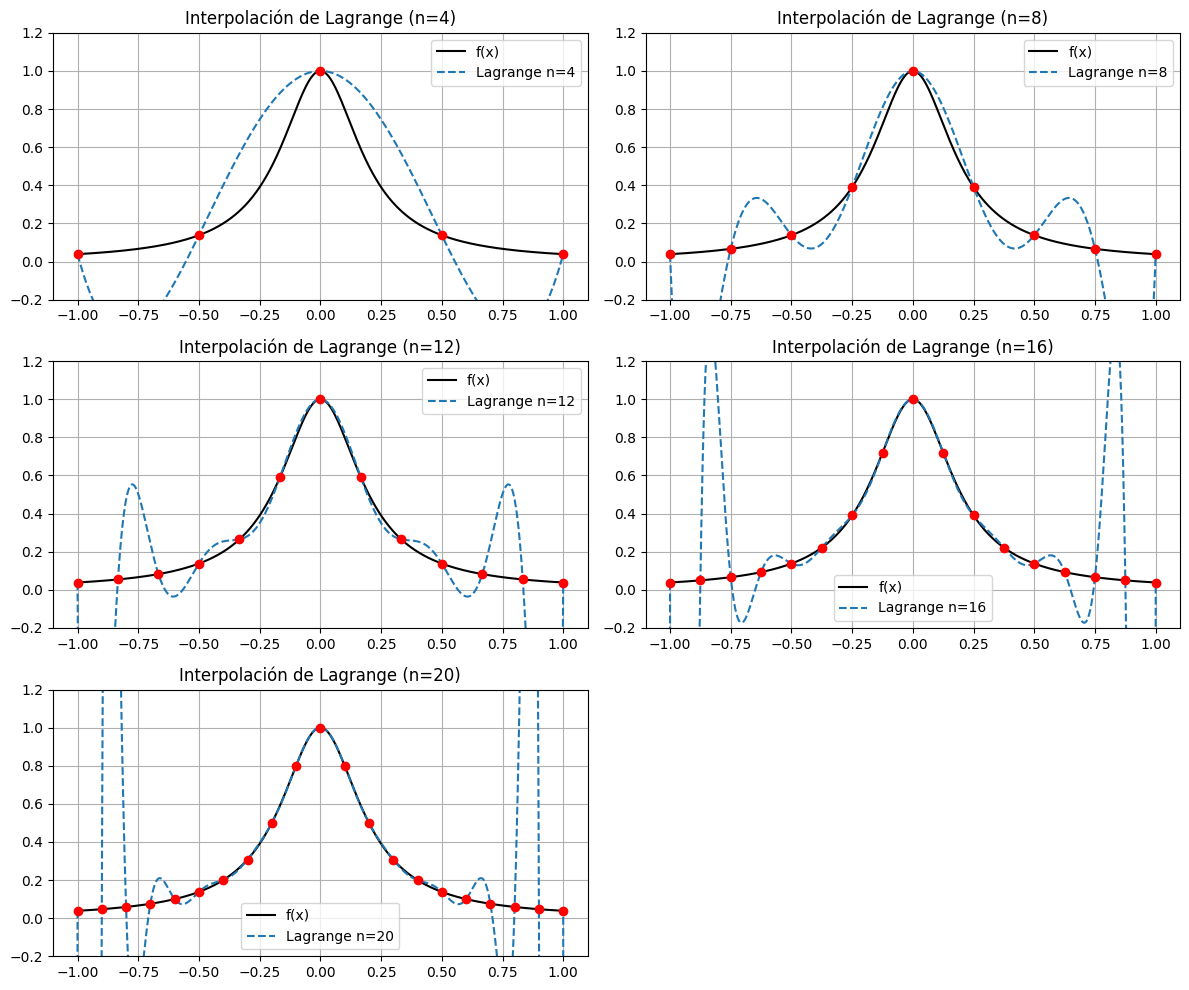

Cota teórica simbólica del error para n=4 en x=0.5:
0


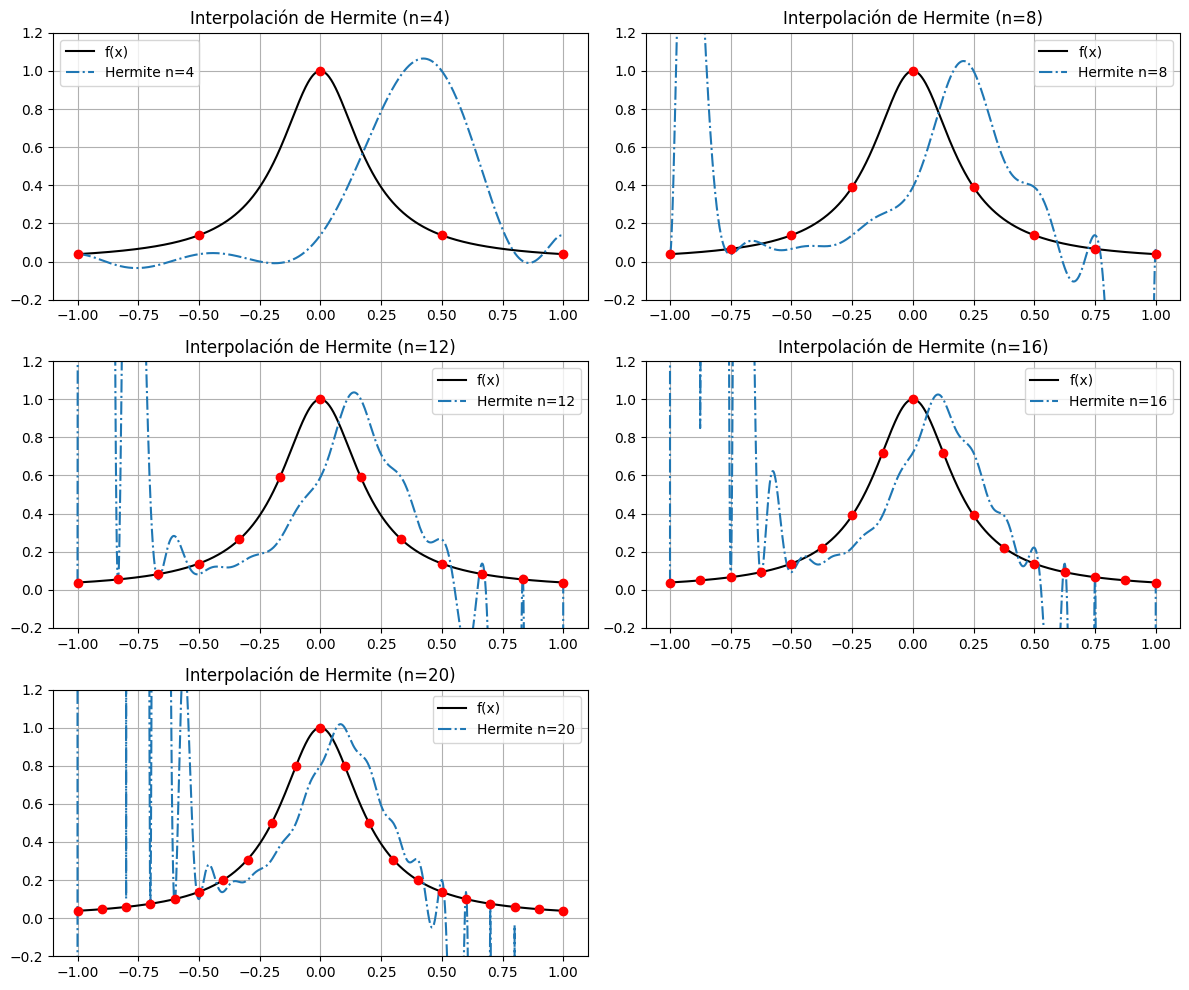

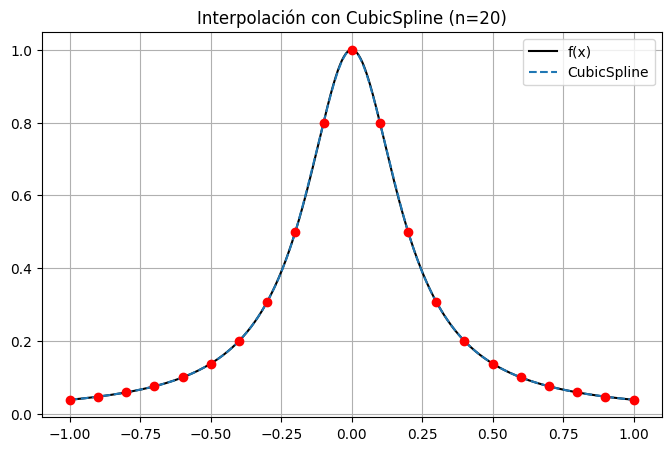

In [17]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Función a interpolar
f = lambda x: 1 / (1 + 25 * x**2)
x_sym = sp.Symbol('x')
f_sym = 1 / (1 + 25 * x_sym**2)

# Cálculo de la cota del error para Lagrange en x = 0.5
def error_teorico_lagrange(f_expr, x_data, x_eval):
    x = sp.Symbol('x')
    n = len(x_data) - 1
    deriv = sp.diff(f_expr, x, n + 1)
    ξ = sp.Symbol('ξ')
    product = 1
    for xi in x_data:
        product *= (x_eval - xi)
    error_expr = (deriv.subs(x, ξ) / sp.factorial(n + 1)) * product
    return sp.simplify(error_expr)

# Parte principal
n_values = [4, 8, 12, 16, 20]
x_eval = 0.5
xx = np.linspace(-1, 1, 1000)

plt.figure(figsize=(12, 10))
for i, n in enumerate(n_values):
    # Puntos de interpolación equiespaciados
    x_nodes = np.linspace(-1, 1, n + 1)
    y_nodes = f(x_nodes)

    # Lagrange
    P_lagrange = lagrange_pol(x_nodes, y_nodes)
    P_lamb = sp.lambdify(x_sym, P_lagrange, 'numpy')
    yy = P_lamb(xx)
    plt.subplot(3, 2, i + 1)
    plt.plot(xx, f(xx), label='f(x)', color='black')
    plt.plot(xx, yy, label=f'Lagrange n={n}', linestyle='--')
    plt.plot(x_nodes, y_nodes, 'ro')
    plt.title(f'Interpolación de Lagrange (n={n})')
    plt.ylim(-0.2, 1.2)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# Cota teórica del error para n=4 en x=0.5
n = 4
x_nodes = np.linspace(-1, 1, n + 1)
error_expr = error_teorico_lagrange(f_sym, x_nodes, x_eval)
print(f"Cota teórica simbólica del error para n=4 en x=0.5:\n{error_expr}")

# Interpolación Hermite con los mismos n
plt.figure(figsize=(12, 10))
for i, n in enumerate(n_values):
    x_nodes = np.linspace(-1, 1, n + 1)
    y_nodes = f(x_nodes)
    P_hermite = hermite_pol(x_nodes, y_nodes)
    P_h_lamb = sp.lambdify(x_sym, P_hermite, 'numpy')
    yy = P_h_lamb(xx)
    plt.subplot(3, 2, i + 1)
    plt.plot(xx, f(xx), label='f(x)', color='black')
    plt.plot(xx, yy, label=f'Hermite n={n}', linestyle='-.')
    plt.plot(x_nodes, y_nodes, 'ro')
    plt.title(f'Interpolación de Hermite (n={n})')
    plt.ylim(-0.2, 1.2)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# CubicSpline para los mismos nodos que n=20
x_nodes = np.linspace(-1, 1, 21)
y_nodes = f(x_nodes)
cs = CubicSpline(x_nodes, y_nodes)
plt.figure(figsize=(8, 5))
plt.plot(xx, f(xx), label='f(x)', color='black')
plt.plot(xx, cs(xx), label='CubicSpline', linestyle='--')
plt.plot(x_nodes, y_nodes, 'ro')
plt.title('Interpolación con CubicSpline (n=20)')
plt.grid(True)
plt.legend()
plt.show()


# 4

Consideremos la imagen ![paloma](https://github.com/hernansalinas/autogrades/blob/main/Laboratorios_Taller/img/paloma.png?raw=true).

Ref: Metodos numericos, Burden.


Con los datos dados en la tabla:

1. Representar gráficamente la imagen, usando las órdenes `imread` e `imshow` de python (estas órdenes están contenidas en el paquete `matplotlib`)

2. Definir una lista de puntos, $x_i$,$y_i$ del pato y realice una interpolación lineal entre los mismos.

3. Representar el polinomio de interpolación de Lagrange en estos puntos, para aproximar el dibujo.

4. Repetir el proceso de interpolación mediante *splines* cúbicos. Para ello, utilizar la función `CubicSpline` (contenida en `scipy.interpolate`),


5. Comparar los resultados. ¿Alguna de las interpolaciones presenta oscilaciones? ¿A qué se debe este fenómeno?

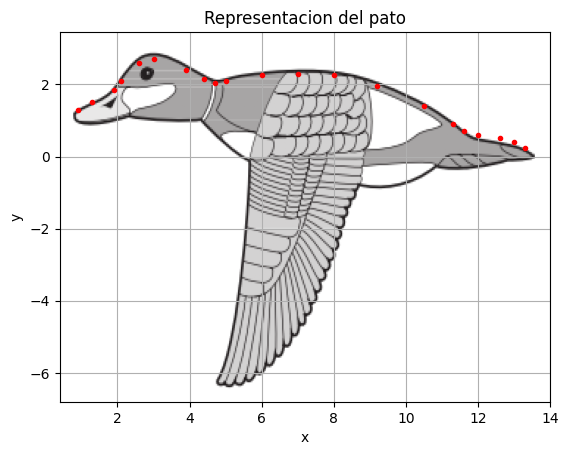

In [ ]:
pato = 'https://3.bp.blogspot.com/-8_LTrCIxVSQ/VxU-5Gq2ffI/AAAAAAAAIto/LhCDEwHKTiAbLr7IhizQwGV13YTwgpbDwCLcB/s400/pato1.png' #URL
urllib.request.urlretrieve(pato, 'pato.jpg')# Decargar la imagen
imagen_pato = plt.imread('pato.jpg') # Variable con la imagen del pato

# Definimos los puntos del pato
xp = [0.9, 1.3, 1.9, 2.1, 2.6, 3.0, 3.9, 4.4, 4.7, 5.0, 6.0, 7.0, 8.0, 9.2, 10.5, 11.3, 11.6, 12.0, 12.6, 13.0, 13.3]
yp = [1.3, 1.5, 1.85, 2.1, 2.6, 2.7, 2.4, 2.15, 2.05, 2.1, 2.25, 2.3, 2.25, 1.95, 1.4, 0.9, 0.7, 0.6, 0.5, 0.4, 0.25]

# Representamos graficamente al pato y los puntos que definimos para su contorno superior
plt.figure()
plt.title('Representacion del pato')
plt.imshow(imagen_pato, extent = (0.4, 14, -6.8, 3.45)) # Ajustamos los pixeles para que coincidan con x e y
plt.plot(xp, yp, '.r')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

# 5

Calcular el spline cúbico que interpola los puntos $(-1,5)$, $(0,3)$, $(1,3)$, $(2,4)$, para esto escriba la matriz asociada y encuentre los polinomios $S_0(x)$, $S_1(x)$ y $S_2(x)$. Evalue su respuesta para $x= 1.5$ usando `CubicSpline` de `scipy`.